In [1]:
#import autoencoders
#/data/alonsoel/workspace/data/crafter
#/data/alonsoel/workspace/data/crafter/dataset_1M_steps_heuristic_crafter
#from 0 to 5727 with ".pt" extension

#and
# /data/alonsoel/workspace/data/crafter/dataset_10M_steps_heuristic_crafter
#from 0 to 28467.pt

# try 2 shapes!

In [2]:
import yaml
import numpy as np
import time
# hyperparameters related to images
get_hyperparam_value = lambda data_dict, hyperparam_name : \
                            [dict_[hyperparam_name] for dict_ in data_dict
                             if hyperparam_name in dict_][0]
                            
hyperparam_path = "/home/novakovm/iris/MILOS/crafter_config.yaml"
with open(hyperparam_path) as f:
    hyperparam_dict = yaml.load(f, Loader=yaml.SafeLoader)

# number of images for training and testing datasets

H, W, C = get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'H'), get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'W'), get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'C')

NUM_EPOCHS =                            get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'NUM_EPOCHS')
NUM_WORKERS =                           get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'NUM_WORKERS') # see what this represents exactly!
USE_PRETRAINED_MODEL  =                 get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'USE_PRETRAINED_MODEL')
USE_GPU =                               get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'USE_GPU')

BATCH_SIZE_TRAIN =                      get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'BATCH_SIZE_TRAIN')
BATCH_SIZE_VAL =                        get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'BATCH_SIZE_VAL')
BATCH_SIZE_TEST =                       get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'BATCH_SIZE_TEST')

LEARNING_RATE =                         get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'LEARNING_RATE')
LEARNING_RATE /= 1e6

TRAIN_DATA_PATH =                       get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'TRAIN_DATA_PATH')
VAL_DATA_PATH =                         get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'VAL_DATA_PATH')
TEST_DATA_PATH =                        get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'TEST_DATA_PATH')
DATA_PATH =                             get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'DATA_PATH')
ROOT_PATH =                             get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'ROOT_PATH')

TRAIN_IMAGES_MEAN_FILE_PATH =           get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'TRAIN_IMAGES_MEAN_FILE_PATH')
TRAIN_IMAGES_STD_FILE_PATH  =           get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'TRAIN_IMAGES_STD_FILE_PATH')

TRAIN_IMAGES_TOTAL_MEAN_FILE_PATH =     get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'TRAIN_IMAGES_TOTAL_MEAN_FILE_PATH')
TRAIN_IMAGES_TOTAL_STD_FILE_PATH  =     get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'TRAIN_IMAGES_TOTAL_STD_FILE_PATH')

MAX_TOTAL_IMAGE_NUMBER =                get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'MAX_TOTAL_IMAGE_NUMBER')
LOGGER_PATH =                           "/home/novakovm/iris/MILOS/crafter_logger.txt"
PCA_decomp_in_every_epochs =            get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'PCA_decomp_in_every_epochs')
run_id =                                get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'run_id')

#GENERATE_DATA_FROM_START =              get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'GENERATE_DATA_FROM_START')
#ONLY_GENERATE_DATA   =                  get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'ONLY_GENERATE_DATA')


GENERATE_DATA=get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'GENERATE_DATA')
PREPROCESS_DATA=get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'PREPROCESS_DATA')
INFERENCE_DATA=get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'INFERENCE_DATA')
# load train/val/test dataset percentage take adds up to 100 (percent)
train_dataset_percentage= get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'train_dataset_percentage')
val_dataset_percentage  = get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'val_dataset_percentage')
test_dataset_percentage = get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'test_dataset_percentage')
assert(100 == train_dataset_percentage + val_dataset_percentage + test_dataset_percentage)

In [3]:
# Import the required libraries
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn

path = "/data/alonsoel/workspace/data/crafter/dataset_1M_steps_heuristic_crafter/"
crafter_batch_id = 1
img_tensor = torch.load(path + f"{crafter_batch_id}.pt")
print(img_tensor.keys())
print(img_tensor['observations'].shape)

B,C,H,W = img_tensor['observations'].shape

dict_keys(['observations', 'actions', 'rewards', 'ends', 'mask_padding'])
torch.Size([149, 3, 64, 64])


/home/novakovm/miniconda3/envs/iris_mn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


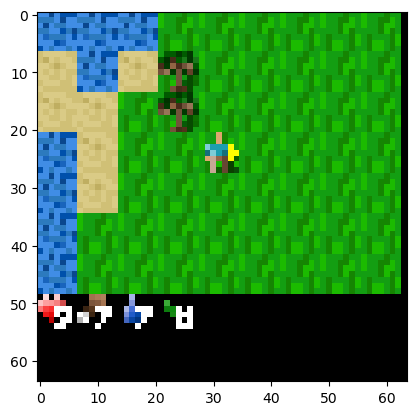

In [4]:
sample_number_in_batch = 56
tensor_image = img_tensor['observations'][sample_number_in_batch,:,:,:]
tensor_image_channel_last_column = tensor_image.permute(1, 2, 0)
plt.imshow(tensor_image_channel_last_column)

In [5]:
import numpy as np
batch_sizes = []
MAX_NUMBER_OF_PT_FILES = 5727
for pt_file_id in range(MAX_NUMBER_OF_PT_FILES):
    img_tensor = torch.load(path + f"{pt_file_id}.pt")
    batch_sizes.append(img_tensor['observations'].shape[0])

batch_sizes = np.array(batch_sizes)
batch_sizes.min(),batch_sizes.mean(),batch_sizes.max()

(7, 174.59734590536058, 440)

In [6]:
print(f"Total number of images = {batch_sizes.sum()}")

Total number of images = 999919


In [7]:
import os
import glob
eloi_data_path = "/data/alonsoel/workspace/data/crafter/dataset_1M_steps_heuristic_crafter/"
MAX_NUMBER_OF_PT_FILES = 5727
root = ROOT_PATH
if not os.path.exists(root):
    os.mkdir(root)
data_paths= {}
data_paths['train'] = TRAIN_DATA_PATH
data_paths['val'] = VAL_DATA_PATH
data_paths['test'] = TEST_DATA_PATH
data_paths['data'] = DATA_PATH

for dataset_str in data_paths:
    data_path = data_paths[dataset_str]
    #make folder if it does not exist
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    #clear the content of the folder
    files = glob.glob(data_path + '*')
    for f in files:
       os.remove(f)

#unique_img_id = 0
unique_image_number = 0

unique_image_number_array = []
for pt_file_id in range(MAX_NUMBER_OF_PT_FILES):
    tensor_img_dsc_path = data_paths['data']
    
    tensor_img_src_path = eloi_data_path
    tensor_img_src_name = f"{pt_file_id}.pt"
    
    loaded_tensor = torch.load(tensor_img_src_path + tensor_img_src_name)
    tensor_imgs = loaded_tensor['observations']
    
    for batch_idx in range(tensor_imgs.size(0)):
        
        #tensor_img_dsc_name = f"{str(TOTAL_IMAGE_NUMBER).zfill(7)}_curr_id_{pt_file_id}_past_id.pt"
        tensor_img_dsc_name = 'color_img_' + str(unique_image_number).zfill(len(str(MAX_TOTAL_IMAGE_NUMBER))) + ".png"
        
        current_img = tensor_imgs[batch_idx, :, :, :].view(C,H,W).cpu().permute(1, 2, 0).numpy() #HWC
        
        plt.imsave(tensor_img_dsc_path+tensor_img_dsc_name, current_img)
        
        #torch.save(tensor_imgs[batch_idx, :, :, :], tensor_img_dsc_path+tensor_img_dsc_name)
        unique_image_number_array.append(unique_image_number)
        unique_image_number += 1
        
        if unique_image_number >= MAX_TOTAL_IMAGE_NUMBER:
            break
        
    if unique_image_number >= MAX_TOTAL_IMAGE_NUMBER:
            break
        
unique_image_number_array = np.array(unique_image_number_array)

In [8]:
SEED=1
np.random.seed(SEED)
shuffled_image_ids = unique_image_number_array.copy()
np.random.shuffle(shuffled_image_ids)
N = len(shuffled_image_ids)
# secure no overlap with train, validation and test datasets
#75% of the dataset
train_shuffled_image_ids = shuffled_image_ids[:int(N* train_dataset_percentage/100)]
#12.5% of the dataset
val_shuffled_image_ids = shuffled_image_ids[int(N* train_dataset_percentage/100):int(N* (train_dataset_percentage/100 + val_dataset_percentage/100))]
#12.5% of the dataset
test_shuffled_image_ids = shuffled_image_ids[int(N* (train_dataset_percentage/100 + val_dataset_percentage/100)):]
#check that everything adds up
assert(N == len(train_shuffled_image_ids) + len(val_shuffled_image_ids) + len(test_shuffled_image_ids))

np.save(ROOT_PATH+"train_shuffled_image_ids.npy", train_shuffled_image_ids)
np.save(ROOT_PATH+"val_shuffled_image_ids.npy", val_shuffled_image_ids)
np.save(ROOT_PATH+"test_shuffled_image_ids.npy", test_shuffled_image_ids)

shuffled_image_ids = {'train':train_shuffled_image_ids, 'val':val_shuffled_image_ids, 'test':test_shuffled_image_ids}

#cut operation from DATA to either DATA_TEST or DATA_VALIDATE or DATA_TEST
for unique_image_number in unique_image_number_array:
    img_src_path = data_paths['data']
    img_src_name = 'color_img_' + str(unique_image_number).zfill(len(str(MAX_TOTAL_IMAGE_NUMBER))) + ".png"
    
    for dataset_str in ['train', 'val', 'test']:
        if unique_image_number in shuffled_image_ids[dataset_str]:
            img_dsc_path = data_paths[dataset_str]
            img_dsc_name = img_src_name # keep the name same
            #cut operation from DATA to either DATA_TEST or DATA_VALIDATE or DATA_TEST
            os.rename(src=img_src_path+img_src_name,dst=img_dsc_path+img_dsc_name)
            



In [9]:

# load train/val/test image ids and check if their number adds up to total number of images
train_shuffled_image_ids= np.load(ROOT_PATH+"train_shuffled_image_ids.npy")
val_shuffled_image_ids  = np.load(ROOT_PATH+"val_shuffled_image_ids.npy")
test_shuffled_image_ids = np.load(ROOT_PATH+"test_shuffled_image_ids.npy")
assert(set(np.concatenate((train_shuffled_image_ids,val_shuffled_image_ids,test_shuffled_image_ids))) == set(np.arange(MAX_TOTAL_IMAGE_NUMBER)))


In [13]:
# calculate variance in data
from preprocessing import find_mean_std

#########################################################
# DATA PREPROCESSING - calculating empirical mean & std #
#########################################################

RGB_mean, RGB_std, RGB_mean_np, RGB_std_np, X_mean_bar_all_ch, X_std_bar_all_ch,  Total_mean_np, Total_std_np = \
find_mean_std(TOTAL_NUMBER_OF_IMAGES = MAX_TOTAL_IMAGE_NUMBER, #for z fill
              image_ids_numbers = train_shuffled_image_ids,
              train_folder_path = TRAIN_DATA_PATH,
              main_folder_path = ROOT_PATH)


#
print(f"Training Images Mean per chanel= {np.round(RGB_mean,2)}")
print(f"Training Images Std per chanel = {np.round(RGB_std,2)}")
print(f"Training Images Mean           = {np.round(X_mean_bar_all_ch,2)}")
print(f"Training Images Std            = {np.round(X_std_bar_all_ch,2)}\n")
#
print(f"Mean (Empirical - np) diff per chanel= {RGB_mean - RGB_mean_np}")
print(f"Std (Empirical - np) diff per chanel = {RGB_std - RGB_std_np}")
print(f"Mean (Empirical - np) diff           = {X_mean_bar_all_ch - Total_mean_np}")
print(f"Std (Empirical - np) diff            = {X_std_bar_all_ch - Total_std_np}")

[ WARN:0@280.998] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/novakovm/DATA_TRAIN/color_img_000003180.png'): can't open/read file: check file path/integrity


IndexError: invalid index to scalar variable.

'/home/novakovm/crafter/'

In [ ]:
from torchvision import transforms

###########################################
# DATA PREPROCESSING - creating Transforms#
###########################################

zero_mean_unit_std_transform = transforms.Compose([
    transforms.Normalize(mean=np.load(TRAIN_IMAGES_MEAN_FILE_PATH).tolist(),
                         std=np.load(TRAIN_IMAGES_STD_FILE_PATH).tolist() )
    ])
zero_min_one_max_transform = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.],
                          std  = [255., 255., 255.])
    ]) # OUTPUT SIGMOID of DNN
minus_one_min_one_max_transform = transforms.Compose([
    transforms.Normalize(mean = [-255./2., -255./2., -255./2.],
                          std  = [255./2., 255./2., 255./2.])
    ]) # OUTPUT (1/2)*TANH of DNN

# Pick one transform that is applied
#TRANSFORM_IMG = zero_min_one_max_transform#zero_mean_unit_std_transform # zero_min_one_max_transform
TRANSFORM_IMG = minus_one_min_one_max_transform#zero_mean_unit_std_transform # zero_min_one_max_transform

In [ ]:
################
# DATA LOADING #
################

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, args, root = False, transform=None):
        self.root = root # './DATA/' = '/home/novakovm/iris/MILOS/DATA/'
        self.transform = transform
        self.TOTAL_NUMBER_OF_IMAGES = args['TOTAL_NUMBER_OF_IMAGES'] # 2048 for test and val; 12'288 for train
        self.image_ids = args['image_ids']# 3314, 2151, 12030, 32, ...
        
    def __len__(self):
        return len(self.image_ids)#self.TOTAL_NUMBER_OF_IMAGES

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = self.root + 'color_img_' + str(image_id).zfill(len(str(self.TOTAL_NUMBER_OF_IMAGES))) + '.png'
        image = torchvision.io.read_image(img_path,mode=torchvision.io.image.ImageReadMode.RGB).float() # .double() = torch.float64 and  .float() = torch.float32
        if self.transform != None:
            image = self.transform(image)
        return image, image_id

# Train Data & Train data Loader
args_train = {'TOTAL_NUMBER_OF_IMAGES' : MAX_TOTAL_IMAGE_NUMBER, 'image_ids' : train_shuffled_image_ids}
train_data = CustomImageDataset(args = args_train, root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
train_data_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=BATCH_SIZE_TRAIN, shuffle=True,  num_workers=NUM_WORKERS)

# Validation Data & Validation data Loader
args_val = {'TOTAL_NUMBER_OF_IMAGES' : MAX_TOTAL_IMAGE_NUMBER, 'image_ids' : val_shuffled_image_ids}
val_data = CustomImageDataset(args = args_val, root=VAL_DATA_PATH, transform=TRANSFORM_IMG)
val_data_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=BATCH_SIZE_VAL, shuffle=True,  num_workers=NUM_WORKERS)

# Test Data & Test data Loader
args_test = {'TOTAL_NUMBER_OF_IMAGES' : MAX_TOTAL_IMAGE_NUMBER, 'image_ids' : test_shuffled_image_ids}
test_data = CustomImageDataset(args = args_test, root=TEST_DATA_PATH, transform=TRANSFORM_IMG)
test_data_loader  = torch.utils.data.DataLoader(dataset = test_data, batch_size=BATCH_SIZE_TEST, shuffle=True, num_workers=NUM_WORKERS) 




In [ ]:
# torchvision.io.read_image(TRAIN_DATA_PATH+ 'color_img_' + str(1).zfill(len(str(MAX_TOTAL_IMAGE_NUMBER))) + '.png',mode=torchvision.io.image.ImageReadMode.RGB).float().shape

In [ ]:
import torch.nn.functional as F
from VQ_VAE import ResidualStack, VectorQuantizer, count_parameters, report_cuda_memory_status

class Manual_Encoder(nn.Module):
    def __init__(self, args_encoder, res_block_args):
        super(Manual_Encoder, self).__init__()
        self.args_encoder = args_encoder
        nb_layers_in_a_block = 2
        C_out_1_init, multiplier_value = 256//8, 2#32 #=256//8  #32#good for K=8 but for higer K (e.g. 128) you can go lower for C_out_1_init to not overfitt the data
        C_out_1_init, multiplier_value = args_encoder['C_out_1_init'],args_encoder['multiplier_value']
        k,s,p=4,2,1
        l=0
        self.sequential_convs = torch.nn.Sequential()
        if self.args_encoder['M'] <= 31: 
            self.sequential_convs.add_module(f"conv2d_{l}", nn.Conv2d(in_channels=3, out_channels=C_out_1_init, kernel_size=k, stride=s, padding=p))
            self.sequential_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 32
        if self.args_encoder['M'] <= 15:
            l+=1
            self.sequential_convs.add_module(f"conv2d_{l}", nn.Conv2d(in_channels=self.sequential_convs[0].out_channels, out_channels=multiplier_value * self.sequential_convs[0].out_channels, kernel_size=k, stride=s, padding=p))
            self.sequential_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 64
        if self.args_encoder['M'] <= 7:
            l+=1
            self.sequential_convs.add_module(f"conv2d_{l}", nn.Conv2d(in_channels=self.sequential_convs[nb_layers_in_a_block].out_channels, out_channels=multiplier_value * self.sequential_convs[nb_layers_in_a_block].out_channels, kernel_size=k, stride=s, padding=p))
            self.sequential_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 128
        if self.args_encoder['M'] <= 3:
            l+=1
            self.sequential_convs.add_module(f"conv2d_{l}", nn.Conv2d(in_channels=self.sequential_convs[2*nb_layers_in_a_block].out_channels, out_channels=multiplier_value * self.sequential_convs[2*nb_layers_in_a_block].out_channels, kernel_size=k, stride=s, padding=p))
            self.sequential_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 256
            
        res_block_args['C_in'] = self.sequential_convs[-nb_layers_in_a_block].out_channels
        self.residual_stack = ResidualStack(res_block_args) 
        
        self.channel_adjusting_conv = nn.Conv2d(in_channels=self.sequential_convs[-nb_layers_in_a_block].out_channels, out_channels=args_encoder['D'], kernel_size=1, stride=1, padding=0)
        #C_out = D
        
    def forward(self, x):
        x = self.sequential_convs(x)
        x = self.residual_stack(x)
        x = self.channel_adjusting_conv(x)
        return x

class Manual_Decoder(nn.Module):
    def __init__(self, args_decoder, res_block_args):
        super(Manual_Decoder, self).__init__()
        self.args_decoder = args_decoder
        
        C_in_1_init, divisor_value = 256, 2 ##256#good for K=8 but for higer K (e.g. 128) you can go lower for C_in_1_init to not overfitt the data
        
        C_in_1_init, divisor_value = args_decoder['C_in_1_init'], args_decoder['divisor_value']
        
        res_block_args['C_in'] = C_in_1_init
        
        self.channel_adjusting_conv = nn.Conv2d(in_channels=args_decoder['D'], out_channels=C_in_1_init, kernel_size=1, stride=1, padding=0)
        self.residual_stack = ResidualStack(res_block_args) 
        self.sequential_trans_convs = torch.nn.Sequential()
        
        nb_layers_in_a_block = 2
        k,s,p=4,2,1
        l=0
        if self.args_decoder['M'] <= 31: 
            self.sequential_trans_convs.add_module(f"trans_conv{l}", nn.ConvTranspose2d(in_channels=C_in_1_init, out_channels = C_in_1_init // divisor_value, kernel_size=k, stride=s, padding=p))
            self.sequential_trans_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 128
        if self.args_decoder['M'] <= 15:
            l+=1
            self.sequential_trans_convs.add_module(f"trans_conv{l}", nn.ConvTranspose2d(in_channels=self.sequential_trans_convs[0].out_channels, out_channels=self.sequential_trans_convs[0].out_channels // divisor_value, kernel_size=k, stride=s, padding=p))
            self.sequential_trans_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 64
        if self.args_decoder['M'] <= 7:
            l+=1
            self.sequential_trans_convs.add_module(f"trans_conv{l}", nn.ConvTranspose2d(in_channels=self.sequential_trans_convs[nb_layers_in_a_block].out_channels, out_channels=self.sequential_trans_convs[nb_layers_in_a_block].out_channels // divisor_value, kernel_size=k, stride=s, padding=p))
            self.sequential_trans_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 32
        if self.args_decoder['M'] <= 3:
            l+=1
            self.sequential_trans_convs.add_module(f"trans_conv{l}", nn.ConvTranspose2d(in_channels=self.sequential_trans_convs[2*nb_layers_in_a_block].out_channels, out_channels=self.sequential_trans_convs[2*nb_layers_in_a_block].out_channels // divisor_value, kernel_size=k, stride=s, padding=p))
            self.sequential_trans_convs.add_module(f"ReLU_{l}", nn.ReLU(True))
            #C_out = 16
            
        self.output_conv_layer =  nn.Conv2d(in_channels=self.sequential_trans_convs[-nb_layers_in_a_block].out_channels, out_channels=3, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        x = self.channel_adjusting_conv(x)
        x = self.residual_stack(x)
        x = self.sequential_trans_convs(x)
        x = self.output_conv_layer(x)
        return x
    
class VQ_VAE(nn.Module):
    def __init__(self, args_encoder, args_VQ, args_decoder, res_block_args_encoder, res_block_args_decoder):
        super(VQ_VAE, self).__init__()
        
        ######################
        # Model Constructors #
        ######################
        self.C_in, self.H_in, self.W_in = args_encoder['C_in'], args_encoder['H_in'], args_encoder['W_in']
        self.args_encoder=args_encoder
        self.args_VQ=args_VQ
        self.args_decoder=args_decoder
        self.res_block_args_encoder = res_block_args_encoder
        self.res_block_args_decoder = res_block_args_decoder
        
        self.train_with_quantization = args_VQ['train_with_quantization']
        
        #self.encoder =  Encoder(self.args_encoder, self.res_block_args_encoder)
        self.encoder =  Manual_Encoder(self.args_encoder, self.res_block_args_encoder)
        if self.train_with_quantization:
            self.VQ      =  VectorQuantizer(args_VQ)
        #self.decoder =  Decoder(self.args_decoder, self.res_block_args_decoder)
        self.decoder =  Manual_Decoder(self.args_decoder, self.res_block_args_decoder)
        

    def forward(self, x):                       #torch.Size([128, 3, 64, 64])
        Ze = self.encoder(x)                    #torch.Size([128, 64, 16, 16])
        
        e_and_q_latent_loss, Zq, e_latent_loss, q_latent_loss, estimate_codebook_words_exp_entropy = None, None, None, None, None
        if self.train_with_quantization:
            e_and_q_latent_loss, Zq, e_latent_loss, q_latent_loss, estimate_codebook_words_exp_entropy = self.VQ(Ze)   #torch.Size([128, 64, 16, 16])
        else:
            e_and_q_latent_loss, Zq, e_latent_loss, q_latent_loss, estimate_codebook_words_exp_entropy =  0, Ze, 0, 0, 0
        x_recon = self.decoder(Zq)              #torch.Size([128, 3, 64, 64])
        return e_and_q_latent_loss, x_recon, e_latent_loss, q_latent_loss, estimate_codebook_words_exp_entropy


In [ ]:
#########################
# VQ-VAE model creation #
#########################
# VQ args
args_VQ = {}
for arg_VQ in ['max_channel_number', 'train_with_quantization', 'D', 'K', 'beta', 'M', 'use_EMA', 'gamma', 'requires_normalization_with_sphere_projection']:
    args_VQ[arg_VQ] = get_hyperparam_value(hyperparam_dict['training_hyperparams'], arg_VQ)
K,D,M = args_VQ['K'],args_VQ['D'],args_VQ['M']
# Encoder Residual Block arguments
res_block_args_encoder = {'block_size' : get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'res_block_size'), 'C_mid' : get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'res_blocks_channel_number_in_hidden_layers')}
# Decoder Residual Block arguments
res_block_args_decoder = {'block_size' : get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'res_block_size'), 'C_mid' : get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'res_blocks_channel_number_in_hidden_layers')}
# Encoder and Decoder args
args_encoder = {'M' : args_VQ['M'], 'D' : args_VQ['D'], 'C_in' : C, 'H_in' : H, 'W_in' : W , 'use_BN' : get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'use_BN')}
args_decoder = {'M' : args_VQ['M'], 'D' : args_VQ['D'], 'use_BN' : get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'use_BN')}

# channel hyper params
nb_of_conv2d_stride_2_layers = {31 : 1, 15: 2, 7: 3, 3: 4, 1:5, 0:6}

args_decoder['C_in_1_init'], args_decoder['divisor_value'] = 256, get_hyperparam_value(hyperparam_dict['training_hyperparams'], 'divisor_value')
args_encoder['C_out_1_init'], args_encoder['multiplier_value'] = args_decoder['C_in_1_init'] // (args_decoder['divisor_value']**(nb_of_conv2d_stride_2_layers[M] - 1)), args_decoder['divisor_value']

# VQ VAE model
model = VQ_VAE(args_encoder, args_VQ, args_decoder, res_block_args_encoder, res_block_args_decoder)
#print(model)
count_parameters(model, path_to_write = LOGGER_PATH)
report_cuda_memory_status()

In [ ]:
#model = vq_vae_implemented_model

# create a trainer init arguments
training_args = {}
training_args['NUM_EPOCHS']         = NUM_EPOCHS
training_args['loss_fn']            = nn.MSELoss()
training_args['device']             = torch.device("cuda:0" if USE_GPU and torch.cuda.is_available() else "cpu") 
training_args['model']              = model #vq_vae_implemented_model
training_args['model_name']         = 'VQ_VAE'
training_args['loaders']            = {'train' : train_data_loader, 'val' : val_data_loader, 'test' : test_data_loader}
training_args['optimizer_settings'] = {'optimization_algorithm':'Adam','lr':LEARNING_RATE}
training_args['logger_path'] = LOGGER_PATH
# if PCA_decomp_in_every_epochs True then it considerably (from 50mins to 70 mins, i.e. 40%!) slows down the training loop!!!
training_args['PCA_decomp_in_every_epochs'] = True
# .item() because it is one element np.array; and we square it because we want variance and not the standard deviation
training_args['train_data_variance'] = np.load(TRAIN_IMAGES_TOTAL_STD_FILE_PATH).item() **2
# because we divided the chanells with TRANSFORM_IMG.std[0] we have to correct the total training data variance for that in other words training_args['train_data_variance'] was VAR[X] but because we did linear transform TRANSFORM_IMG so that X -> (X - MEAN_TRANSFORM_IMG) / STD_TRANSFORM_IMG we need to adjust the total variance of the data from VAR[X] -> VAR[(X - MEAN_TRANSFORM_IMG) / STD_TRANSFORM_IMG] = VAR[X] / STD_TRANSFORM_IMG**2 and that is precicely what we are doing here
training_args['train_data_variance'] /= (TRANSFORM_IMG.transforms[0].std[0]**2)
# training_args['train_data_variance']=1.
print(f"Inverse of training data variance term is equal to =  {1. / training_args['train_data_variance']:.1f}")


In [ ]:
from models import Model_Trainer
compressed_number_of_bits_per_image = int(np.ceil(np.log2(model.args_VQ['K']))) * (model.args_VQ['M']+1) ** 2

trainer_folder_path = ROOT_PATH + \
                      str(run_id).zfill(3) + "_" + training_args['model_name'] + \
                      '_K_' + str(model.args_VQ['K']) + \
                      '_D_' + str(model.args_VQ['D']) + \
                      '_M_' + str(model.args_VQ['M']) + \
                      '_bits_' + str(compressed_number_of_bits_per_image)
training_args['main_folder_path']   = trainer_folder_path

if not(os.path.exists(trainer_folder_path)):
    os.system(f'mkdir {trainer_folder_path}')

# create a trainer object
trainer = Model_Trainer(args=training_args)

In [ ]:
if not USE_PRETRAINED_MODEL:
    current_time_str = time.strftime("%H:%M:%S %d.%m.%Y", time.gmtime(time.time()))
    log_str = f"[{current_time_str}] {run_id}) Started running for K = {K} & D = {D} & M = {M} & beta = {model.args_VQ['beta']} & max_channel_number = {args_decoder['C_in_1_init']} (i.e. bits = {compressed_number_of_bits_per_image}) change_channel_size_across_layers by factor = {args_decoder['divisor_value']}"
    
    with open(LOGGER_PATH, 'a') as f:
        # get current time in the format hh:mm:ss DD.MM.YYYY
        f.write(f"****************************************************************************************************************\n\n")
        f.write(f"----- {current_time_str} BEGIN RUN -----\n\n")
        f.write(f"Started {log_str}:\n\n--------------------------------------------------- \n\n")

    START_TIME = time.time()
    #train
    trainer.train()
    #train
    TOTAL_TRAINING_TIME = int(np.floor(time.time() - START_TIME))
    minutes, seconds = divmod(TOTAL_TRAINING_TIME, 60)
    hours, minutes = divmod(minutes, 60)
    TOTAL_TRAINING_TIME = f"{hours}:{minutes}:{seconds} h/m/s"
    
    # get current time in the format hh:mm:ss DD.MM.YYYY
    current_time_str = time.strftime("%H:%M:%S %d.%m.%Y", time.gmtime(time.time()))
    with open(LOGGER_PATH, 'a') as f:
        f.write(f"Finished {log_str}:\nTotal training time is = {TOTAL_TRAINING_TIME}. \n\n--------------------------------------------------- \n\n")
        f.write(f"----- {current_time_str} END RUN -----\n\n****************************************************************************************************************\n\n")


In [ ]:
if USE_PRETRAINED_MODEL:
    ##########################    
    # Use a pretrained model #
    ##########################
    trainer.epoch_ids_PCA = list(range( int(0.05*trainer.NUM_EPOCHS), trainer.NUM_EPOCHS + 1, int(0.05*trainer.NUM_EPOCHS)))
    
    if run_id == 600:
        current_time_str = "2023_01_18_01_34_27" # "YYYY_MM_DD_HH_MM_SS" 
    else:
        assert(False)
    
    # load model that was trained at newly given current_time_str 
    trainer.load_model(current_time_str = current_time_str, autoencoder_config_params_wrapped_sorted= None)

    # load avg. training loss of the training proceedure for a model that was trained at newly given current_time_str 
    trainer.train_loss_avg = np.load(trainer.main_folder_path + '/' + trainer.model_name + '_train_loss_avg_' + trainer.current_time_str + '.npy')
    
    # load avg. validation loss of the validating proceedure for a model that was trained at newly given current_time_str 
    trainer.val_loss_avg = np.load(trainer.main_folder_path + '/' + trainer.model_name + '_val_loss_avg_' + trainer.current_time_str + '.npy')
    
    # Load individual loss terms for both training and validation datasets
    trainer.usage_of_multiple_terms_loss_function = True
    # Training Loss data per term
    trainer.train_multiple_losses_avg = {}
    
    # Validation Loss data per term
    trainer.val_multiple_losses_avg = {}
    
    # Training Loss data per term file path
    trainer.train_multiple_losses_avg_path = {}
    
    # Validation Loss data per term file path
    trainer.val_multiple_losses_avg_path = {}
    
    for loss_term in ['reconstruction_loss','commitment_loss', 'VQ_codebook_loss']:
        # Training Loss data per term file path
        trainer.train_multiple_losses_avg_path[loss_term] = trainer.main_folder_path + '/' + trainer.model_name + '_train_multiple_losses_avg_' + loss_term + '_'  + trainer.current_time_str + '.npy'
        
        # Validation Loss data per term file path
        trainer.val_multiple_losses_avg_path[loss_term]   = trainer.main_folder_path + '/' + trainer.model_name + '_val_multiple_losses_avg_' + loss_term + '_'  + trainer.current_time_str + '.npy'
        
        # Training Loss data per term
        trainer.train_multiple_losses_avg[loss_term] = np.load(trainer.train_multiple_losses_avg_path[loss_term])
        
        # Validation Loss data per term
        trainer.val_multiple_losses_avg[loss_term]   = np.load(trainer.val_multiple_losses_avg_path[loss_term])
    
    # Load Perplexity over epochs during training
    trainer.train_metrics, trainer.val_metrics = {}, {}    
    trainer.train_metrics_perplexity_path = trainer.main_folder_path + '/' + trainer.model_name + '_train_perplexity_' + trainer.current_time_str + '.npy'
    trainer.val_metrics_perplexity_path = trainer.main_folder_path + '/' + trainer.model_name + '_val_perplexity_' + trainer.current_time_str + '.npy'
    trainer.train_metrics['perplexity'] = np.load(trainer.train_metrics_perplexity_path)
    trainer.val_metrics['perplexity'] = np.load(trainer.val_metrics_perplexity_path)

In [ ]:
from models import visualise_output
#########################
### Testing the model ###
#########################
loss_fn = trainer.loss_fn
loss_fn.to(trainer.device)
trainer.test() 

#############################################################################
# Plot train and validation avergae loss across mini-batch across epochs #
# Plot Test Loss for every sample in the Test set #
#############################################################################
trainer.plot()


############################################################
# Plot top-N worst reconstructed test images
# [with their original test images side by side
# and rank them from worst (highest reconstruction loss value)
# to best reconstructed test image]
############################################################
TOP_WORST_RECONSTRUCTED_TEST_IMAGES = 50
trainer.get_worst_test_samples(TOP_WORST_RECONSTRUCTED_TEST_IMAGES)
trainer.model.eval()
visualise_output(images             = trainer.worst_top_images, 
                 model              = trainer.model,
                 compose_transforms = TRANSFORM_IMG,
                 imgs_ids           = trainer.worst_imgs_ids,
                 imgs_losses        = trainer.worst_imgs_losses,
                 savefig_path       = trainer.main_folder_path + '/WORST_RECONSTRUCTED_TEST_IMAGES.png',
                 device = trainer.device)

############################################################
# Plot top-N best reconstructed test images
# [with their original test images side by side
# and rank them from best (lowest reconstruction loss value)
# to worst reconstructed test image]
############################################################
TOP_BEST_RECONSTRUCTED_TEST_IMAGES = 50
trainer.get_best_test_samples(TOP_BEST_RECONSTRUCTED_TEST_IMAGES)
trainer.model.eval()
visualise_output(images             = trainer.best_top_images, 
                 model              = trainer.model,
                 compose_transforms = TRANSFORM_IMG,
                 imgs_ids           = trainer.best_imgs_ids,
                 imgs_losses        = trainer.best_imgs_losses,
                 savefig_path       = trainer.main_folder_path + '/BEST_RECONSTRUCTED_TEST_IMAGES.png',
                 device = trainer.device)



In [ ]:


################################################
### Training & Validation metrics visualized ###
################################################
if not USE_PRETRAINED_MODEL:
    trainer.plot_perlexity()

#####################################################################
### Codebook (a matrix of codewords) and Tokens Z_Q visualization ###
#####################################################################
#trainer.codebook_visualization()#nije bitno
#trainer.plot_codebook_PCA()
trainer.visualize_discrete_codes(compose_transforms = TRANSFORM_IMG, dataset_str = 'test')

In [ ]:
USE_PRETRAINED_MODEL